In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, plot_results, split_retrain
from exp_hp import get_hp

2024-08-14 11:03:19.271558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 11:03:21.126871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [3]:
def scheduler(epoch, lr):
    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    if (epoch < 20) or (epoch % 20 != 0):
        return lr
    else:
        return lr * tf.constant(.5,dtype=tf.float32)

### Load Standardized CESM2-LE

In [4]:
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain_increase'

hps = get_hp(EXP_NAME2)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

Training Members: [['0201'], ['0201', '0211'], ['0201', '0211', '0221'], ['0201', '0211', '0221', '0231'], ['0201', '0211', '0221', '0231', '0241'], ['0201', '0211', '0221', '0231', '0241', '0251'], ['0201', '0211', '0221', '0231', '0241', '0251', '0261'], ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271'], ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']]
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E


### TRAIN CNN2 (transfer learning --> using CNN1 weights)

In [5]:
# ---------- NEW CNN Hyperparameters ----------
NLABEL = 2
HIDDENS = [128] 
BATCH_SIZE = 64
N_EPOCHS = 100
LR_INIT = 0.0001
RIDGE = 1.0
PATIENCE = 10
OPTIMIZER = 'adam'

GLOBAL_SEED = 99
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)


0
loading data & saving
made it!
0


2024-08-14 11:03:57.151852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 861 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-08-14 11:03:59.367174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-14 11:04:00.062115: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-14 11:04:00.118609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-14 11:04:00.192477: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1486ec5b4e90 initialized for platform CUDA (t

Elapsed time during fit = 1.42 minutes



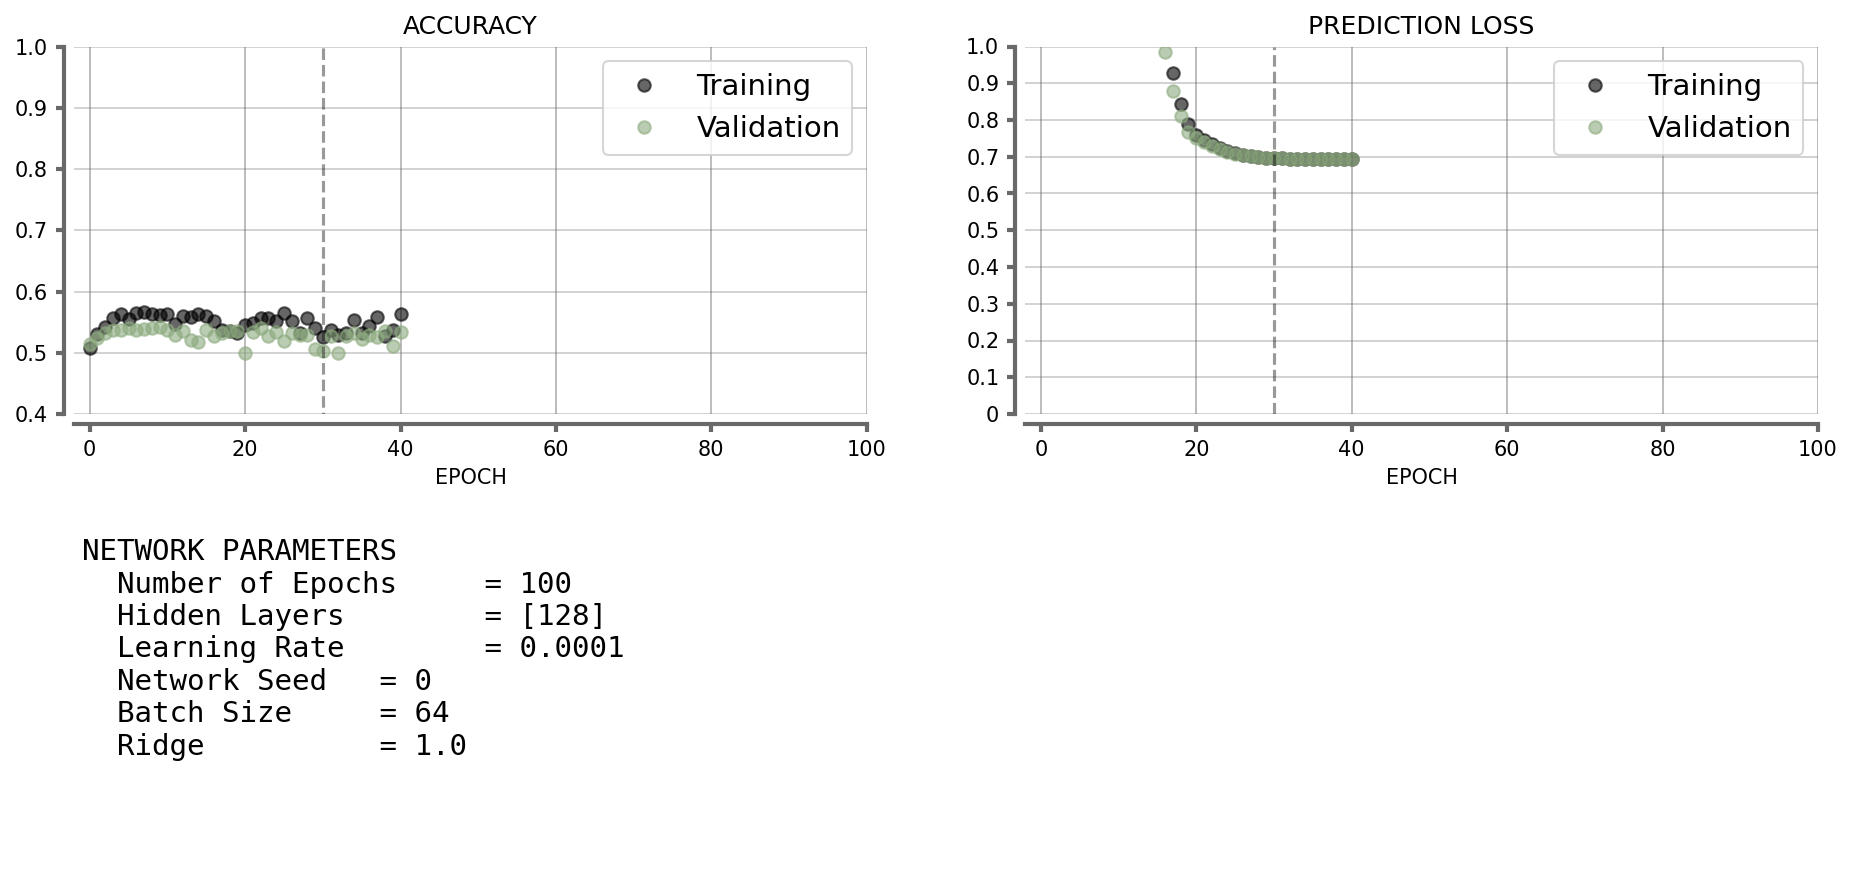

1
Elapsed time during fit = 1.37 minutes



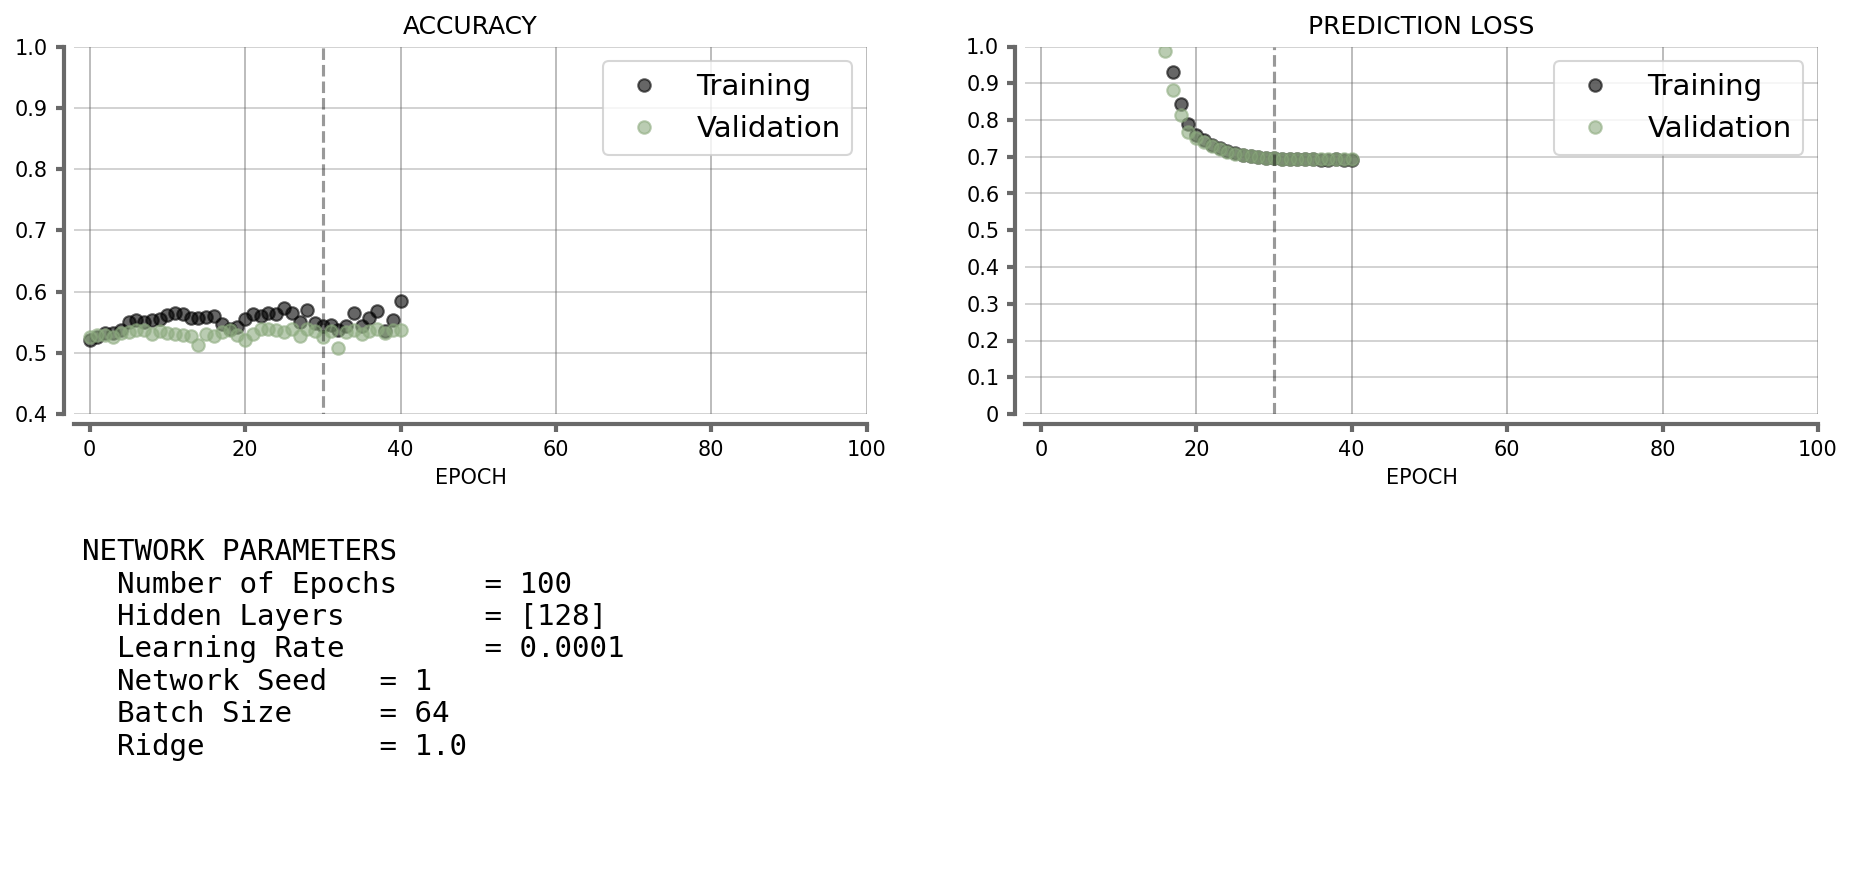

2


KeyboardInterrupt: 

In [6]:
#----- SET UP & TRAIN NN -----
for mm in np.arange(0,9):
    print(mm)
    Xtrain, Xval, _, Ytrain, Yval, _, _ = split_retrain(trainmems = hps['train_mems'][mm],
                                                              valmem = hps['val_mems'][0],
                                                              testmem = hps['test_mems'][0],
                                                              months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                              lead = hps['LEAD'])
    
    for SEED in range(10):
        print(SEED)
        tf.keras.backend.clear_session() 
    
        # ----- load base model -----
        # reload base model each time it trains because it gets written over when training... idk why
        cnn1fi_name = 'cnn1_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
        cnn1 = tf.keras.models.load_model(base_dir+'CNNcheck/saved_models/'+cnn1fi_name)
        cnn1.trainable = False
        
        # ------ define dense layers ------
        # remove layers back to flatten layer & add new dense layers
        x = cnn1.layers[-4].output 
        
        # x = tf.keras.layers.Flatten()(x)
        
        # additional layers
        for h,hiddens in enumerate(HIDDENS):
            x = tf.keras.layers.Dense(hiddens,
                                      activation = 'relu',
                                      use_bias = True,
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer= tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer= tf.keras.initializers.RandomNormal(seed=SEED),
                                      name = 'dense_2_'+str(h)
                                     )(x)
        # output layer w/ softmax
        output_layer = tf.keras.layers.Dense(2,
                                             activation = tf.keras.activations.softmax,
                                             use_bias = True,
                                             kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                             bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                             kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                             name = 'dense_3'
                                             )(x)
    
        #create model
        cnn2 = tf.keras.Model(inputs=cnn1.input, outputs=output_layer)
        # cnn2.summary()
        
        # ------ Training Hyperparameters ------
        if OPTIMIZER == 'adam':
            optimizer = tf.optimizers.Adam(learning_rate = LR_INIT)
        elif OPTIMIZER == 'sgd':
            optimizer = tf.optimizers.SGD(learning_rate = LR_INIT,momentum = MOM) # determines the number of previously seen training samples are used to update weights
    
        loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             
    
        # ------ Compile Model -----
        cnn2.compile(optimizer = optimizer,
                     loss = loss_func,
                     metrics = metrics)
    
        # ----- Callbacks -----
        ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.005,
                                              patience = PATIENCE, verbose = 0, restore_best_weights = True)
        LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)
    
        # ------ Train -----
        start_time = time.time()
        history = cnn2.fit(Xtrain,Ytrain,
                          validation_data = [Xval,Yval],
                          batch_size = BATCH_SIZE,
                          epochs = N_EPOCHS,
                          shuffle = True,
                          verbose = 0,
                          callbacks = [ES,LR])
        stop_time = time.time()
        tf.print(f"Elapsed time during fit = {(stop_time - start_time)/60.:.2f} minutes\n")
    
        #----- PLOT THE RESULTS -----
        plot_results(
            history,
            exp_info=(100, HIDDENS, LR_INIT, BATCH_SIZE, SEED, PATIENCE, RIDGE),
            showplot=True
        ) 
    
        cnn2fi_name = 'cnn2_'+EXP_NAME+'.'+str(mm)+'_seed'+str(SEED)+'.h5'
        cnn2.save(base_dir+'CNNcheck/saved_models/'+cnn2fi_name)